# How to Build a Machine Learning Model for Chemical Property Prediction

> This notebook shows how to build a simple but strong machine-learning model for the prediction of **logP** (water-octanol partition coefficient).
- toc: True
- metadata_key1: QSPR
- metadata_key2: logP
- metadata_key3: machine learning

This notebook shows how to build a simple but strong machine-learning model for the prediction of **logP** (octanol-water partition coefficient). 

  The **logP** is quite an important property in medicinal and pharmaceutical chemistry, as it relates to the distribution of drugs between aqueous phases (hydrophilic phases such as blood) and other non-aqueous compartments in the human body.

The approach is tested on the recent **SAMPL7 blind challenge** dataset showing excellent results here.

In fact this approach can be used to predict any chemical property as long as their
is enough chemical data for model building, i.e. in the form of several hundred or better thousands SMILES and property pairs.  

**Never** use this approach for small datasets, i.e. use at least a few 100 samples if possible. That is a common mistake i.e. using the machinery of ML on small datasets without doing the due diligent statistics - paving the way for "predictive" models being much to over-confident, which look great in theory and academic papers but failing terribly in real-world practice!

## Used libraries:

* [RDKit](https://www.rdkit.org/)
* [lightgbm](https://lightgbm.readthedocs.io/en/latest/)
* [pandas](https://pandas.pydata.org/)
* [scikit-learn](https://scikit-learn.org/stable/)

## Used data:

* [Opera curated physprop dataset(s)](https://epa.figshare.com/articles/dataset/PHYSPROP_Analysis_File_12_14_2016/5588578/2)
* [SAMPL7 logP blind challenge data](https://github.com/samplchallenges/SAMPL7)

# Overview & individual steps

1. [Load experimental data](#Loading-the-data)
2. [Compute descriptors](#Computing-descriptors)
3. [Compute fingerprints](#Computing-fingerprints-as-descriptors)
4. [Model building](#Model-training)
5. [Parameter selection](#Parameter-selection)
6. [Deployment & Analysis](#Deployment-&-Analysis-of-the-results)

### First loading all needed python libraries

In [1]:
# technical & general libraries
from tqdm.notebook import tqdm

# data science libraries
import pandas as pd
import lightgbm as lgb

from sklearn.model_selection import KFold,cross_val_score, train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error

from joblib import dump, load

# cheminformatics
from rdkit.Chem import AllChem as Chem
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem import Descriptors
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import Draw

# set some options for better visibility of DataFrames
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth', 1000)

## Loading the data

We start with loading training and test set data from [SD files](https://en.wikipedia.org/wiki/Chemical_table_file). Those files contain the molecular structure and the corresponding chemical property, here the logP value. The data can be found as an updated version [here](https://github.com/kmansouri/OPERA) and the original published data [here](https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0263-1#Sec23).
We use a built-in library from RDKit to create a list of molecules and logP value pairs from it, in total more than 10000 samples.  

Those pairs are saved in a list of dictionaries which can then be used to create a pandas DataFrame from it.
This DataFrame is a very useful data structure which allows easy handling of tabular data.  

For now we use only the provided training data, there is also another SD file with test data, which we leave aside completety for now and which could be used later on to finally test the results.

Lets start with downloading and unzipping the data from the source:

In [ ]:
!wget -O ./opera_data.zip https://ndownloader.figstatic.com/files/10692997
#wget -O ./opera_data.zip https://github.com/kmansouri/OPERA/blob/master/OPERA_Data.zip?raw=true # github data
!unzip ./opera_data.zip

We start with creating a DataFrame from the downloaded SD file.   
We ignore for now also some error message coming from parsing the molecular structures.

In [ ]:
sd_file = './OPERA_LogP/TR_LogP_10537.sdf'
#sd_file = './LogP_QR.sdf' # github data
suppl = Chem.SDMolSupplier(sd_file)
data = []
for m in tqdm(suppl):
    if m is None: continue
    smiles = Chem.MolToSmiles(m)
    data.append({'SMILES': smiles, 'logP': m.GetProp('LogP')})

df = pd.DataFrame(data) 
df['logP'] = df['logP'].astype(float) # convert from string to float
df

Now we have a pandas DataFrame with SMILES, encoding the molecular topology, and experimental logP values.

## Computing descriptors

RDKit provides a nice tool to compute any kind of descriptors:

In [ ]:
calculator = MoleculeDescriptors.MolecularDescriptorCalculator([x[0] for x in Descriptors._descList])
calculator.GetDescriptorNames()

Lets understand how the descriptor calculator from RDKit works.  
It takes a molecule and returns a `tuple` 
of all RDKit descriptors for this molecule, 200 in total.

In [6]:
calculator.CalcDescriptors??

In [7]:
len(calculator.CalcDescriptors(Chem.MolFromSmiles("CCO")))

200

In [8]:
def smiles2desc(s):
    descriptors = calculator.CalcDescriptors(Chem.MolFromSmiles(s))
    return descriptors

Lets first create a pandas series and then turn this (pandas) series of tuples into a pandas DataFrame containing all descriptors. This might take a while...   
Certainly we do not need all of those descriptors. Later we will find a way to select the descriptors we need.

We then save the DataFrame for later use and save some time during model development. By the way with the `%%time` command the cpu and wall times for running the code in a jupyter cell can be measured.

In [9]:
%%time
desc_tuples = df['SMILES'].apply(smiles2desc)
X = pd.DataFrame(desc_tuples.tolist(), columns = calculator.GetDescriptorNames())
X

CPU times: user 1min 11s, sys: 1.4 s, total: 1min 12s
Wall time: 1min 11s


,MaxEStateIndex,MinEStateIndex,MaxAbsEStateIndex,MinAbsEStateIndex,qed,MolWt,HeavyAtomMolWt,ExactMolWt,NumValenceElectrons,NumRadicalElectrons,MaxPartialCharge,MinPartialCharge,MaxAbsPartialCharge,MinAbsPartialCharge,FpDensityMorgan1,FpDensityMorgan2,FpDensityMorgan3,BalabanJ,BertzCT,Chi0,Chi0n,Chi0v,Chi1,Chi1n,Chi1v,Chi2n,Chi2v,Chi3n,Chi3v,Chi4n,Chi4v,HallKierAlpha,Ipc,Kappa1,Kappa2,Kappa3,LabuteASA,PEOE_VSA1,PEOE_VSA10,PEOE_VSA11,PEOE_VSA12,PEOE_VSA13,PEOE_VSA14,PEOE_VSA2,PEOE_VSA3,PEOE_VSA4,PEOE_VSA5,PEOE_VSA6,PEOE_VSA7,PEOE_VSA8,PEOE_VSA9,SMR_VSA1,SMR_VSA10,SMR_VSA2,SMR_VSA3,SMR_VSA4,SMR_VSA5,SMR_VSA6,SMR_VSA7,SMR_VSA8,SMR_VSA9,SlogP_VSA1,SlogP_VSA10,SlogP_VSA11,SlogP_VSA12,SlogP_VSA2,SlogP_VSA3,SlogP_VSA4,SlogP_VSA5,SlogP_VSA6,SlogP_VSA7,SlogP_VSA8,SlogP_VSA9,TPSA,EState_VSA1,EState_VSA10,EState_VSA11,EState_VSA2,EState_VSA3,EState_VSA4,EState_VSA5,EState_VSA6,EState_VSA7,EState_VSA8,EState_VSA9,VSA_EState1,VSA_EState10,VSA_EState2,VSA_EState3,VSA_EState4,VSA_EState5,VSA_EState6,VSA_EState7,VSA_EState8,VSA_EState9,FractionCSP3,HeavyAtomCount,NHOHCount,NOCount,NumAliphaticCarbocycles,NumAliphaticHeterocycles,NumAliphaticRings,NumAromaticCarbocycles,NumAromaticHeterocycles,NumAromaticRings,NumHAcceptors,NumHDonors,NumHeteroatoms,NumRotatableBonds,NumSaturatedCarbocycles,NumSaturatedHeterocycles,NumSaturatedRings,RingCount,MolLogP,MolMR,fr_Al_COO,fr_Al_OH,fr_Al_OH_noTert,fr_ArN,fr_Ar_COO,fr_Ar_N,fr_Ar_NH,fr_Ar_OH,fr_COO,fr_COO2,fr_C_O,fr_C_O_noCOO,fr_C_S,fr_HOCCN,fr_Imine,fr_NH0,fr_NH1,fr_NH2,fr_N_O,fr_Ndealkylation1,fr_Ndealkylation2,fr_Nhpyrrole,fr_SH,fr_aldehyde,fr_alkyl_carbamate,fr_alkyl_halide,fr_allylic_oxid,fr_amide,fr_amidine,fr_aniline,fr_aryl_methyl,fr_azide,fr_azo,fr_barbitur,fr_benzene,fr_benzodiazepine,fr_bicyclic,fr_diazo,fr_dihydropyridine,fr_epoxide,fr_ester,fr_ether,fr_furan,fr_guanido,fr_halogen,fr_hdrzine,fr_hdrzone,fr_imidazole,fr_imide,fr_isocyan,fr_isothiocyan,fr_ketone,fr_ketone_Topliss,fr_lactam,fr_lactone,fr_methoxy,fr_morpholine,fr_nitrile,fr_nitro,fr_nitro_arom,fr_nitro_arom_nonortho,fr_nitroso,fr_oxazole,fr_oxime,fr_para_hydroxylation,fr_phenol,fr_phenol_noOrthoHbond,fr_phos_acid,fr_phos_ester,fr_piperdine,fr_piperzine,fr_priamide,fr_prisulfonamd,fr_pyridine,fr_quatN,fr_sulfide,fr_sulfonamd,fr_sulfone,fr_term_acetylene,fr_tetrazole,fr_thiazole,fr_thiocyan,fr_thiophene,fr_unbrch_alkane,fr_urea
0,8.000000,2.000000,8.000000,2.000000,0.360624,30.026,28.010,30.010565,12,0,0.106382,-0.307097,0.307097,0.106382,1.500000,1.500000,1.500000,2.000000,2.000000,2.000000,1.115355,1.115355,1.000000,0.288675,0.288675,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.33,2.000000e+00,1.670000,0.670000,-5.360303,12.900773,4.794537,6.789076,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,4.794537,6.789076,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,6.789076,4.794537,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,17.07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.789076,0.000000,4.794537,0.000000,0.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,2,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,-0.1849,7.1210,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,16.859063,-1.980464,16.859063,0.067556,0.667213,392.467,363.235,392.199902,154,0,0.189906,-0.389712,0.389712,0.189906,1.321429,2.000000,2.642857,1.837692,804.748825,20.698306,16.613088,16.613088,12.963233,10.142335,10.142335,9.749151,9.749151,8.791253,8.791253,7.261033,7.261033,-1.37,1.500076e+06,19.925309,5.832748,2.014264,163.871786,15.319582,12.207933,17.235250,0.000000,0.0,0.000000,9.589074,4.390415,0.0,0.0,25.496599,56.594876,16.747887,6.103966,29.299072,11.566490,0.0,0.000000,28.583699,63.828275,6.606882,23.801165,0.0,0.000000,0.000000,4.390415,0.000000,0.000000,50.866731,9.589074

In [10]:
X.to_csv('tmp.csv',index=False)

## Computing circular fingerprints as descriptors

This step is optional - you can also directly proceed to the [model training](#Model-training).
For comparison lets also use Morgan fingerprints /[ECFP](https://pubs.acs.org/doi/10.1021/ci100050t) as descriptors.   There is some nice overview on different fingerprints also in this [presentation](https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf).

Here also RDKit provides some nice function for fingerprint generation, lets understand how they work:

In [11]:
Chem.GetMorganFingerprintAsBitVect??
n_bits = 2048
fp = Chem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles("CCO"),2,nBits=n_bits)

In [12]:
def smiles2fingerprints(s):
    fp = Chem.GetMorganFingerprintAsBitVect(Chem.MolFromSmiles(s),2,nBits=n_bits)
    return [int(x) for x in fp.ToBitString()]

In [13]:
%%time
fp_tuples = df['SMILES'].apply(smiles2fingerprints)

CPU times: user 3.97 s, sys: 56 ms, total: 4.03 s
Wall time: 4.02 s


In [14]:
fp_names = ['fp'+str(i) for i in range(n_bits)]
X_fp = pd.DataFrame(fp_tuples.tolist(), columns = fp_names)
X_fp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10527 entries, 0 to 10526
Columns: 2048 entries, fp0 to fp2047
dtypes: int64(2048)
memory usage: 164.5 MB


In [15]:
X_fp.to_csv('tmp_fp.csv',index=False)

In case we want to use fingerprints instead as descriptors, just load the `tmp_fp.csv` dataframe now instead of the `tmp.csv`.

In [16]:
X = pd.read_csv('tmp.csv')
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10527 entries, 0 to 10526
Columns: 200 entries, MaxEStateIndex to fr_urea
dtypes: float64(96), int64(104)
memory usage: 16.1 MB


In [17]:
y = df.logP

Check if we have still the correct dimensions for the train data and the target data.

In [18]:
assert(X.shape[0]==len(y))

## Model training

Lets prepare the training. We are using the [lightgbm](https://lightgbm.readthedocs.io/en/latest/) library, which uses [stochastic gradient boosting](https://www.sciencedirect.com/science/article/abs/pii/S0167947301000652) for model building, which is currently the most effective way to train tabular data like this.    
There are several libraries for this, another quite commonly used library is [XGBoost](https://xgboost.readthedocs.io/en/latest/get_started.html).   

There are a lot of parameters to tune. We only use the most important ones. You can find more info on the parameters to choose on the [LightGBM homepage](https://lightgbm.readthedocs.io/en/latest/Parameters.html).


We use an 80/20 split for train and validation set. The validation is kept aside and with the training set we perform a 5-fold cross-validation.


In [19]:
lgb_params = {'num_leaves': 128,
                  'min_child_samples': 79,
                  'objective': 'regression',
                  'max_depth': 15,
                  'learning_rate': 0.01,
                  "boosting_type": "gbdt",
                  "subsample_freq": 1,
                  "subsample": 0.5,
                  "bagging_seed": 11,
                  "metric": 'mae',
                  "verbosity": -1,
                  'reg_alpha': 0.1,
                  'reg_lambda': 0.3,
                  'colsample_bytree': 1.0,
                  'n_estimators': 4000,
                  'n_jobs': -1,
                  }

model = lgb.LGBMRegressor(**lgb_params)
cv = KFold(n_splits=5, shuffle=True, random_state=42)
Xtrain, Xval, ytrain, yval = train_test_split(X, y, test_size=0.20, random_state=42, shuffle=True)
print(Xtrain.shape)
print(Xval.shape)

(8421, 200)
(2106, 200)


Now we actually fit the model, this also may take a while. You can adjust the `n_jobs` parameter to improve performance. You may also change the `verbosity` parameter in order to get more feedback during the calculation. 

Lets also remove some of the features. We do this by looking at the feature importance. There are more advanced methods for feature selection but for the sake of brevity we just use this. For simplicity we also use the API of lightgbm itself.

In [ ]:
model.fit(Xtrain, ytrain, early_stopping_rounds=100,eval_metric=['l1'], eval_set=[(Xtrain, ytrain), (Xval, yval)])

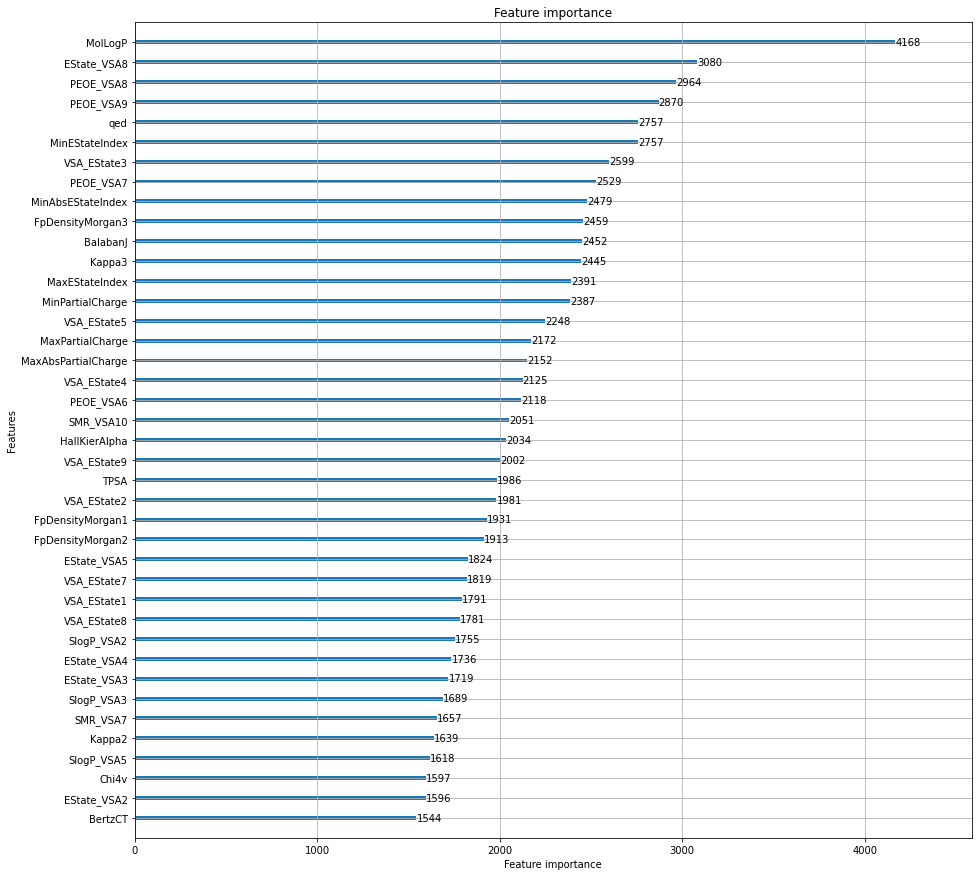

In [21]:
lgb.plot_importance(model, max_num_features=40, figsize=(15,15))

Not as a suprise, the predicted logP by the internal RDKit module is by far the most important feature. At least this shows, that the setup so far is correct and in fact the ML model learns basically some corrections to this internal logP model.

Lets remove unimportant features, the threshold is somewhat arbitrary, but could of course be optimized further. 

In [22]:
feature_imp = pd.DataFrame(sorted(zip(model.feature_importances_,X.columns),reverse=True), columns=['Value','Feature'])
feature_imp = feature_imp.loc[feature_imp.Value>10]
feature_imp.shape

(146, 2)

In [23]:
Xtrain = Xtrain[feature_imp.Feature]
Xval = Xval[feature_imp.Feature]

Note this kind of selection is not perfectly clean, as it would have been more correct to carry out the feature selection without peaking at the experimental training data. There are also some more elaborated (and more time-consuming) methods for feature selection, such as [recursive feature elimination](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFE.html). 

Now we do a cross-validation with the selected features. For the cross-validation the RSME ([root mean squared error](https://en.wikipedia.org/wiki/Root-mean-square_deviation)) should be about 0.52 with the RDKit standard descriptors. We also get the standard deviation in order to see how each fold varies from the mean.

In [24]:
results = cross_val_score(model, Xtrain, ytrain, cv=cv, scoring='neg_mean_squared_error', )
print("\nResults: %.2f (%.2f) RMSE" % ((-1 * results.mean())**0.5, (results.std())**0.5))


Results: 0.52 (0.16) RMSE


## Parameter selection

OK - now lets improve the results a bit by optimisation of the LGBM parameters. We vary the learning rate, the sub sampling, i.e. how much of the data samples is left aside for each tree (*stochastic* gradient boosting), and the maximal depth of the regression trees. The number of estimators we set high enough in order to give the classifier the opportunity to do early stopping by monitoring the validation set.

We use basically a gridsearch on the parameter space and here also scikit learn offers the tools for doing this, via the `GridSearchCV` class. Of course we do this using cross-validation in order not to overfit.

Note the `refit` keyword we use, it allows us to return the best estimator after the grid search.  

This step may also take a while, depending on how many parameters we change. Keep in mind that each additional parameter doubles the number of runs for the grid search. Therefore, instead of a grid search sometimes more sophisticated [global search algorithms](https://papers.nips.cc/paper/2011/file/86e8f7ab32cfd12577bc2619bc635690-Paper.pdf) are used for *hyperparameter* tuning.

In [ ]:
%%time
parameters = {'n_estimators': [5000], 'learning_rate': [0.01,0.02,0.03],'subsample':[0.5,0.75], 'max_depth': [12,15]}
model = GridSearchCV(model, parameters, scoring='neg_mean_squared_error',cv=cv, n_jobs = 4,refit=True, verbose=0)
model.fit(Xtrain, ytrain, early_stopping_rounds=100,eval_metric=['l1','l2'], eval_set=[(Xtrain, ytrain), (Xval, yval)])
df_res = pd.DataFrame(model.cv_results_)
df_res['rmse'] = (-1*df_res['mean_test_score'])**0.5
print(df_res[['rmse','params','rank_test_score']].sort_values('rank_test_score',ascending=True))

The RMSE should be around 0.50 and a sensible set of parameters should be for the standard RDKit descriptors:   
{'learning_rate': 0.02, 'max_depth': 12, 'n_estimators': 5000, 'subsample': 0.75}

For the fingerprints:
RMSE =0.77 and some possible parameters
{'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 5000, 'subsample': 1.0}

The fingerprints based model seems to be significantly worse than the one with classical descriptors.

Note, that we deploy the model (and the selected features!), so that we can re-use it later on.   
We use the joblib library, which goes well with scikit-learn models, but we could also have used python `pickle` command here.

In [26]:
dump(model, 'lgbm_logp.joblib')
dump(feature_imp.Feature, 'features.joblib')

['features.joblib']

## Deployment & Analysis of the results

Now lets check the model. We use the data from the [SAMPL7 blind challenge](https://github.com/samplchallenges/SAMPL7). 

In [27]:
df = pd.read_csv('https://raw.githubusercontent.com/samplchallenges/SAMPL7/master/physical_property/SAMPL7_molecule_ID_and_SMILES.csv')
df_exp = pd.read_csv('https://raw.githubusercontent.com/samplchallenges/SAMPL7/master/physical_property/experimental_data/Experimental_Properties_of_SAMPL7_Compounds.csv')
df_exp.rename({'logP ': 'logP'},inplace=True,axis=1) # lets remove the ugly white space
df = df.merge(df_exp[['Molecule ID','logP']],left_on='SAMPL7 Molecule ID',right_on='Molecule ID')
df

,SAMPL7 Molecule ID,isomeric SMILES,Molecule ID,logP
0,SM25,O=C(NS(C1=CC=CC=C1)(=O)=O)CCC2=CC=CC=C2,SM25,2.67
1,SM26,O=S(CCC1=CC=CC=C1)(NC(C)=O)=O,SM26,1.04
2,SM27,O=S(CCC1=CC=CC=C1)(NC2(C)COC2)=O,SM27,1.56
3,SM28,O=S(CC1(NC(C)=O)CCC2=CC=CC=C2)(C1)=O,SM28,1.18
4,SM29,CS(NC1(COC1)CCC2=CC=CC=C2)(=O)=O,SM29,1.61
5,SM30,O=S(NC1(COC1)CCC2=CC=CC=C2)(C3=CC=CC=C3)=O,SM30,2.76
6,SM31,O=S(NC1(COC1)CCC2=CC=CC=C2)(N(C)C)=O,SM31,1.96
7,SM32,CS(NC1(CSC1)CCC2=CC=CC=C2)(=O)=O,SM32,2.44
8,SM33,O=S(NC1(CSC1)CCC2=CC=CC=C2)(C3=CC=CC=C3)=O,SM33,2.96
9,SM34,O=S(NC1(CSC1)CCC2=CC=CC=C2)(N(C)C)=O,SM34,2.83


Lets have a look at the molecules first.

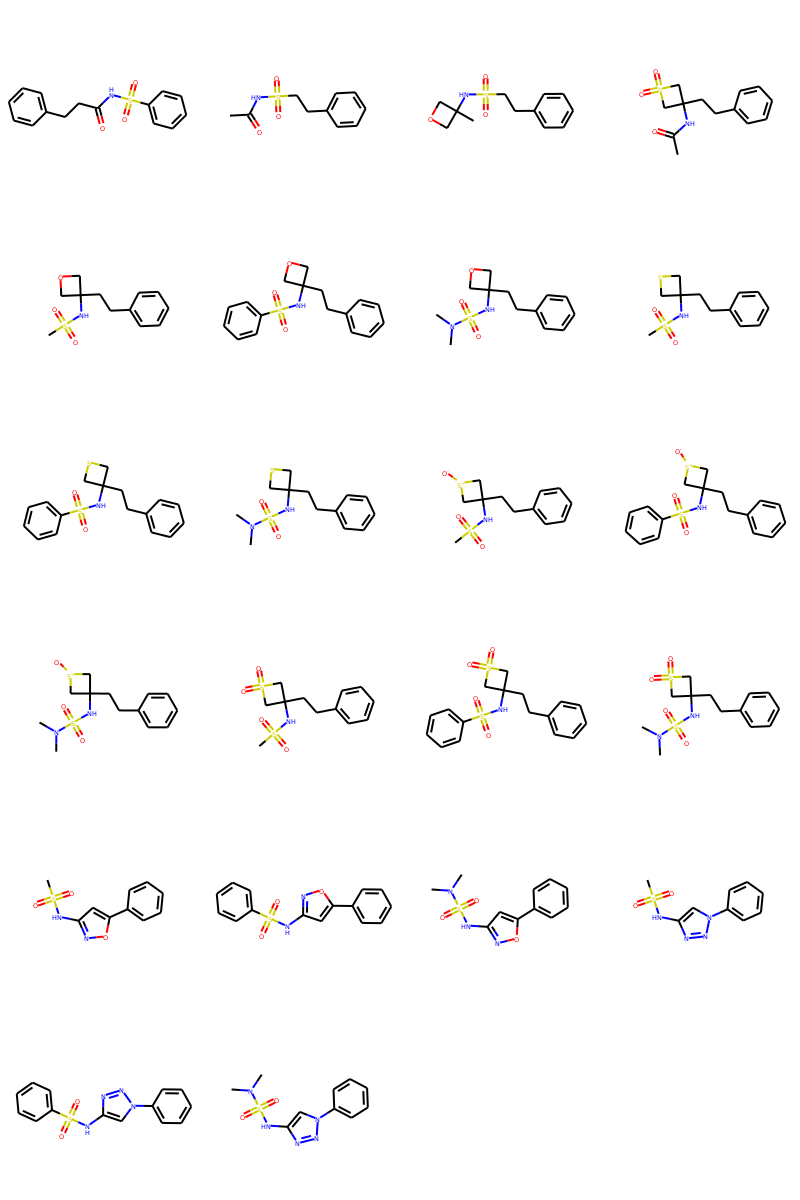

In [47]:
tmp_ms = [Chem.MolFromSmiles(x) for x in df['isomeric SMILES'].values]
Draw.MolsToGridImage(tmp_ms,molsPerRow=4,subImgSize=(200,200))

Now lets build a function that takes a list of SMILES and outputs the corresponding logP values using our previous build model:

In [31]:
def predict_logp(smiles):
    # generate desriptors
    desc_list = list(map(smiles2desc,smiles))
    Xtest = pd.DataFrame(desc_list, columns = calculator.GetDescriptorNames())
    
    # load the relevant column names
    columns = load('features.joblib')
    Xtest = Xtest[columns]
    
    # load the model
    model = load('lgbm_logp.joblib')
    ypred = model.predict(Xtest)
    return ypred
    

In [32]:
smiles = df['isomeric SMILES'].values
df['ypred'] = predict_logp(smiles)
mae = mean_absolute_error(df.logP, df['ypred'])
mse = mean_squared_error(df.logP, df['ypred'])
print("MAE: %6.2f RMSE: %6.2f" % (mae,mse**0.5)) 

MAE:   0.59 RMSE:   0.68


### Conclusions
 
 Not bad - the obtained RMSE would have been around the *3rd position* in the [SAMPL7 logP challenge](https://github.com/samplchallenges/SAMPL7/blob/master/physical_property/logP/analysis/analysis_outputs_ranked_submissions/StatisticsTables/statistics.csv).  
But also note the small dataset size (n=22) and the particular domain, i.e. mostly sulfonamids for this challenge, which of course is not sufficient to get a robust statistic for general model performance. So keep in mind having *always* a sufficiently large and representative validation set at hand.

 With a very simple setup and using a set of common python libraries we can build and deploy very accurate  QSPR like  machine learning models. Its very likely that this logP model could be improved with even more accurate data, machine learning models are data hungry, do not expect to get good results with a just hand ful of data points.    
Quite importantly, a curated dataset was used for model building, i.e. having a high noise level in the dataset usually detoriates gradient boosting regressors significantly and for such datasets more robust regressors/classifiers such as Random Forest should be used.
 
 Below some results for different runs (the score of the internal RDKit logP model with the opera dataset is RMSE=0.87 and for the SAMPL7 dataset RMSE=0.88 by the way):

|dataset|RMSE,CV|n|dataset|MAE|RMSE|n|descriptors|
|-|-|-|-|-|-|-|-|
|OPERA|0.52|10547  |SAMPL7| 0.59| 0.68 |22|RDKit MoleculeDescriptors|
|OPERA|0.50 |13962|SAMPL7| 0.66| 0.77 |22|RDKit MoleculeDescriptors|
|OPERA|0.87 |10547| SAMPL7|0.80| 1.10|22|RDKit Morgan Fingerprints|
|OPERA|0.78|13962|SAMPL7| 0.79|1.09 |22|RDKit Morgan Fingerprints|


